In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
import random

def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 100
    model.Params.MIPGap = 0.05
    model.Params.Presolve = 2
    model.Params.MIPFocus = 1
    model.Params.Heuristics = 0.8
    model.Params.Threads = 8

In [2]:
# Parameters
m = 8
K = 5
L_levels = [25, 20, 15, 12, 10]
E_levels = [13, 28, 38, 45, 120] 
E_PU_max = [8000] * m # limit 650
CPU_capacity = [3000] * m
f_v_levels = [30, 40, 60, 80, 100]
P_idle = [16] * m
P_max = [40] * m
T_total = 300
total_tasks = 150
from collections import Counter

# Task chain definitions
chain_tasks = {
    0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    1: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    2: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    3: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
    4: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
    5: [50, 51, 52, 53, 54, 55, 56, 57],
    6: [58, 59, 60],
    7: [61, 62, 63],
    8: [64, 65, 66],
    9: [67, 68, 69],
    10: [70, 71, 72],
    11: [73, 74, 75],
    12: [76, 77, 78],
    13: [79, 80, 81],
    14: [82, 83, 84],
    15: [85, 86, 87],
    16: [88, 89, 90],
    17: [91, 92, 93],
    18: [94, 95, 96],
    19: [97, 98, 99]
}

num_chains = len(chain_tasks)
n = max(max(v) for v in chain_tasks.values()) + 1  # Total number of tasks
buffer = 0.2  # 允许 20% 裕度
L_max = [int(len(chain_tasks[k]) * min(L_levels) * (1 + buffer)) for k in chain_tasks]


# 找出所有短链编号（例如任务数 ≤ 5 的）
short_chain_ids = [k for k, v in chain_tasks.items() if len(v) <= 5]

# 找出所有长链中的任务索引
long_chain_tasks = [i for k, v in chain_tasks.items() if k not in short_chain_ids for i in v]

def run_short_chain_only(alpha_1, alpha_2, alpha_3, E_PU_max_value=5200):
    print(f"\n🔬 Testing ONLY Short Chains (E_PU_max={E_PU_max_value})")
    result = run_gurobi_model(
        alpha_1=alpha_1,
        alpha_2=alpha_2,
        alpha_3=alpha_3,
        baseline=False,
        E_PU_max=[E_PU_max_value] * m,
        force_disable_tasks=long_chain_tasks  # 👈 下面需要支持这个参数
    )
    
    if result is None:
        print("❌ Infeasible even with only short chains.")
    else:
        print(f"✅ Accepted Chains = {result['Accepted Chains']}, Objective = {result['Objective Value']:.2f}")
        print("📋 Activated Chains:", result["Activated Chain List"])

        for j, task_list in result["PU Task Assignment"].items():
            print(f"PU {j}: Tasks = {task_list}")

        for i, k in enumerate(result["Task Energy Levels"]):
            if k >= 0:
                print(f"Task {i}: y[i,k]={k}, Energy={E_levels[k]}")



def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False, E_PU_max=None, force_disable_tasks=None):
    model = gp.Model("MAF_Optimization")
    configure_model(model)
    if E_PU_max is None:
        E_PU_max = [8000] * m  # 默认最大能耗

    
    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    z = model.addVars(num_chains, vtype=GRB.BINARY, name="z")
    E_PU = model.addVars(m, name="E_PU")
    if force_disable_tasks is not None:
        for i in force_disable_tasks:
            model.addConstr(delta[i] == 0)
    if baseline:
        for i in range(n):
            model.addConstr(y[i, K - 1] == delta[i])
            for k in range(K - 1):
                model.addConstr(y[i, k] == 0)

    for i in range(n):
        model.addConstr(gp.quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(gp.quicksum(y[i, k] for k in range(K)) == delta[i])
        for k in range(K):
            model.addConstr(y[i, k] <= delta[i])  # Ensure y[i,k]=0 if task is inactive

    for k in range(num_chains):
        model.addConstr(gp.quicksum(delta[i] for i in chain_tasks[k]) == z[k] * len(chain_tasks[k]))
        delay_chain = gp.quicksum(y[i, k_] * L_levels[k_] for i in chain_tasks[k] for k_ in range(K))
        model.addConstr(delay_chain <= L_max[k])

    for j in range(m):
        model.addConstr(
            gp.quicksum(w[i, j] * gp.quicksum(y[i, k] * f_v_levels[k] for k in range(K)) for i in range(n)) <= CPU_capacity[j]
        )
        active_time = gp.quicksum(w[i, j] * gp.quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        U_j = active_time / T_total
        E_PU_expr = P_idle[j] * (T_total - active_time) + (P_max[j] - P_idle[j]) * U_j * T_total
        model.addConstr(E_PU[j] == E_PU_expr)
        model.addConstr(E_PU[j] <= E_PU_max[j])

    total_task_energy = gp.quicksum(y[i, k] * E_levels[k] for i in range(n) for k in range(K))
    total_chain_accept = gp.quicksum(z[k] for k in range(num_chains))
    total_pu_energy = gp.quicksum(E_PU[j] for j in range(m))

    model.setObjective(
        alpha_1 * total_chain_accept - alpha_2 * total_task_energy - alpha_3 * total_pu_energy,
        GRB.MAXIMIZE
    )


    model.write("model_before_optimize.lp")  # 可选：查看未优化前的模型
    start_time = time.time()
    model.optimize()
    end_time = time.time()
    model.write("model_after_optimize.lp")   # 可选：查看优化后（含约束状态）



    if model.status == GRB.INFEASIBLE:
        print("🚫 Infeasible model! Computing IIS...")
        model.computeIIS()
        model.write("model_infeasible.ilp")
        print("\n🚨 Infeasible Constraints in IIS:")
        for c in model.getConstrs():
            if c.IISConstr:
                print(f" - {c.constrName}")
        return None

    if model.status != GRB.OPTIMAL:
        print("❌ Model optimization failed (status =", model.status, ").")
        return None


    print(f"⏱️ Gurobi Runtime: {end_time - start_time:.2f} seconds")
    print("\n📋 Chain Activation Overview:")
    for k in range(num_chains):
        status = "✅ Activated" if z[k].X > 0.5 else "❌ Not activated"
        task_list = chain_tasks[k]
        print(f"Chain {k}: {status}, Tasks: {task_list}")

    accepted_chains = [k for k in range(num_chains) if z[k].X > 0.5]
    pu_assignment = [j for i in range(n) for j in range(m) if w[i, j].X > 0.5]
    pu_task_map = {}
    for task_id, pu_id in enumerate(pu_assignment):
        pu_task_map.setdefault(pu_id, []).append(task_id)

    task_energy_levels = [max((y[i, k].X, k) for k in range(K))[1] if delta[i].X > 0.5 else -1 for i in range(n)]
    

    return {
        "Mode": "Baseline" if baseline else "Non-Baseline",
        "Objective Value": model.ObjVal,
        "Accepted Chains": len(accepted_chains),
        "Total PU Energy": sum(E_PU[j].X for j in range(m)),
        "Total Task Energy": sum(y[i, k].X * E_levels[k] for i in range(n) for k in range(K)),
        "Runtime": model.Runtime,
        "PU Task Assignment": pu_task_map,
        "Task Energy Levels": task_energy_levels,
        "Activated Chain List": [1 if z[k].X > 0.5 else 0 for k in range(num_chains)]
    }

In [6]:
def test_acceptance_vs_E_PU_max(
    alpha_1=8000, alpha_2=10, alpha_3=2,
    start=6000, stop=4500, step=-100,
    short_chain_only=False,
    baseline=False
):
    results = []
    for E in range(start, stop + step, step):
        print(f"\n🔬 Testing E_PU_max = {E}")
        
        if short_chain_only:
            result = run_gurobi_model(
                alpha_1=alpha_1,
                alpha_2=alpha_2,
                alpha_3=alpha_3,
                E_PU_max=[E] * m,
                baseline=baseline,
                force_disable_tasks=[i for k, v in chain_tasks.items() if len(v) > 5 for i in v]
            )
        else:
            result = run_gurobi_model(
                alpha_1=alpha_1,
                alpha_2=alpha_2,
                alpha_3=alpha_3,
                E_PU_max=[E] * m,
                baseline=baseline
            )
        
        if result is None:
            results.append((E, 0, "infeasible"))
        else:
            results.append((E, result['Accepted Chains'], "feasible"))

    return results




🔬 Testing E_PU_max = 5800
⏱️ Gurobi Runtime: 2.48 seconds

📋 Chain Activation Overview:
Chain 0: ❌ Not activated, Tasks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Chain 1: ✅ Activated, Tasks: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Chain 2: ❌ Not activated, Tasks: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Chain 3: ✅ Activated, Tasks: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Chain 4: ✅ Activated, Tasks: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Chain 5: ✅ Activated, Tasks: [50, 51, 52, 53, 54, 55, 56, 57]
Chain 6: ✅ Activated, Tasks: [58, 59, 60]
Chain 7: ✅ Activated, Tasks: [61, 62, 63]
Chain 8: ✅ Activated, Tasks: [64, 65, 66]
Chain 9: ✅ Activated, Tasks: [67, 68, 69]
Chain 10: ✅ Activated, Tasks: [70, 71, 72]
Chain 11: ✅ Activated, Tasks: [73, 74, 75]
Chain 12: ✅ Activated, Tasks: [76, 77, 78]
Chain 13: ✅ Activated, Tasks: [79, 80, 81]
Chain 14: ✅ Activated, Tasks: [82, 83, 84]
Chain 15: ✅ Activated, Tasks: [85, 86, 87]
Chain 16: ✅ Activated, Tasks: [88, 89, 90]
Chain 17: ✅ Activated, Tasks: [9

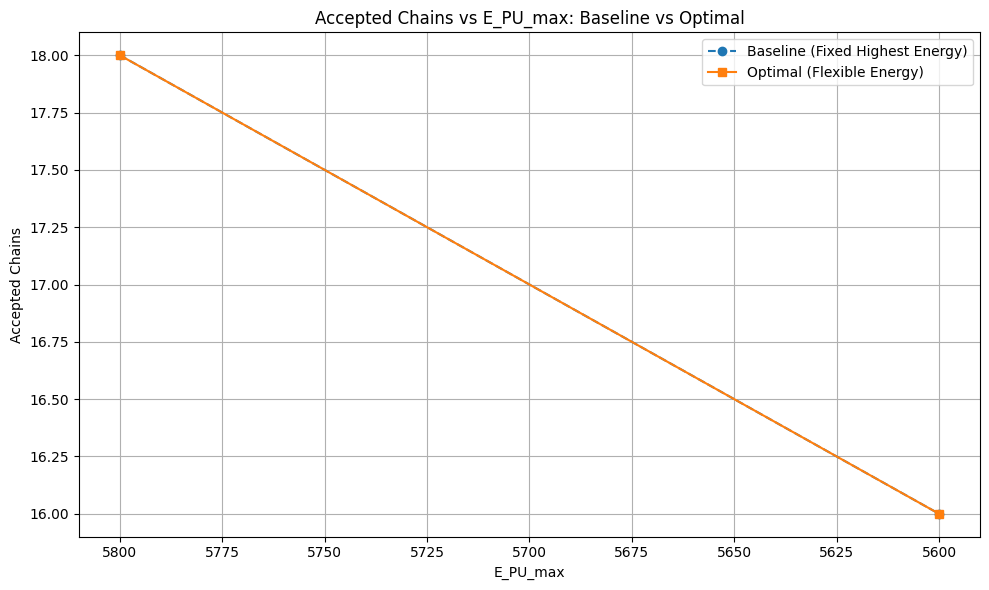

In [8]:
results_baseline = test_acceptance_vs_E_PU_max(
    alpha_1=8000,
    alpha_2=10,
    alpha_3=2,
    start=5800,
    stop=5600,
    step=-200,
    short_chain_only=False  # 全部任务链
)

results_optimal = test_acceptance_vs_E_PU_max(
    alpha_1=8000,
    alpha_2=10,
    alpha_3=2,
    start=5800,
    stop=5600,
    step=-200,
    short_chain_only=False,
    baseline=False
)

for E, chains, status in results_baseline:
    print(f"E_PU_max = {E} → Chains Accepted = {chains} ({status})")





import matplotlib.pyplot as plt
# Extract for plotting
x_base = [E for E, c, s in results_baseline]
y_base = [c for E, c, s in results_baseline]

x_opt = [E for E, c, s in results_optimal]
y_opt = [c for E, c, s in results_optimal]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_base, y_base, marker='o', label='Baseline (Fixed Highest Energy)', linestyle='--')
plt.plot(x_opt, y_opt, marker='s', label='Optimal (Flexible Energy)', linestyle='-')
plt.gca().invert_xaxis()
plt.xlabel("E_PU_max")
plt.ylabel("Accepted Chains")
plt.title("Accepted Chains vs E_PU_max: Baseline vs Optimal")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



📋 Baseline Results:
E_PU_max = 5800 → Chains Accepted = 18 (feasible)
E_PU_max = 5600 → Chains Accepted = 16 (feasible)

📋 Optimal Results:
E_PU_max = 5800 → Chains Accepted = 18 (feasible)
E_PU_max = 5600 → Chains Accepted = 16 (feasible)


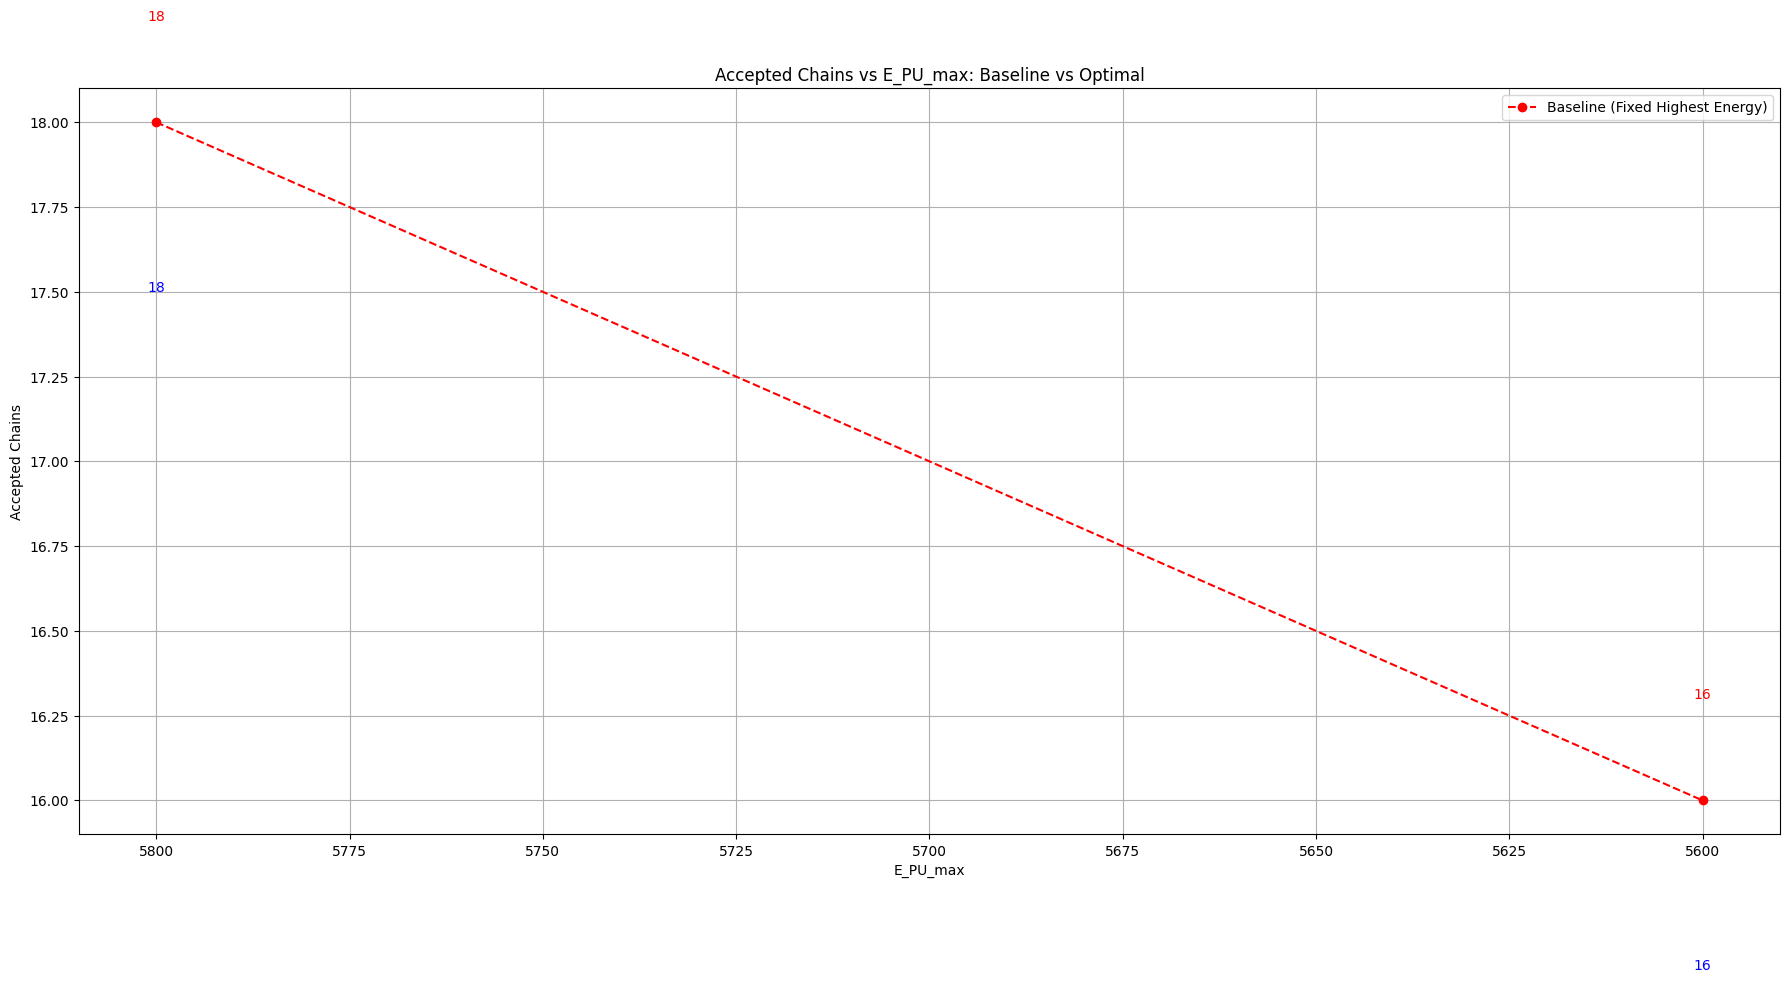

In [12]:
print("\n📋 Baseline Results:")
for E, chains, status in results_baseline:
    print(f"E_PU_max = {E} → Chains Accepted = {chains} ({status})")

print("\n📋 Optimal Results:")
for E, chains, status in results_optimal:
    print(f"E_PU_max = {E} → Chains Accepted = {chains} ({status})")

plt.figure(figsize=(18, 10))
plt.plot(x_base, y_base, marker='o', label='Baseline (Fixed Highest Energy)', linestyle='--', color='red')
#plt.plot(x_opt, y_opt, marker='s', label='Optimal (Flexible Energy)', linestyle='-', color='blue')

for x, y in zip(x_base, y_base):
    plt.text(x, y + 0.3, f'{y}', ha='center', color='red')

for x, y in zip(x_opt, y_opt):
    plt.text(x, y - 0.5, f'{y}', ha='center', color='blue')

plt.gca().invert_xaxis()
plt.xlabel("E_PU_max")
plt.ylabel("Accepted Chains")
plt.title("Accepted Chains vs E_PU_max: Baseline vs Optimal")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
